In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf


# 将 MScProject 目录添加到 Python 模块搜索路径
sys.path.append(os.path.abspath('..'))
# 从 DataGenerate.py 导入 DataGenerate 类 用于pickle导入
from DataGenerate import TrainValidManage


In [2]:
# 加载 config.yaml 文件
config = OmegaConf.load("../config/config.yaml")

# 打印完整的配置内容
print(OmegaConf.to_yaml(config))

base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
data_generation:
  load_data:
    node_mean: 50.0
    node_var: 10.0
    node_iid_var: 5.0
    node_theta: 0.9
  latency:
    mean: 0.0
    var: 0.0
    iid_var: 0.0
    theta: 0.0
exp4:
  batch_size: 64
  seq_length: 20
  input_size: 10
  output_size: 10
  learning_rate: 0.001
  num_epochs: 100
  num_workers: 24
  device: cuda
  mix_precision: true
  patience_epochs: 6
  min_delta: 0.01
  mode: min
  factor: 0.1
  patience_lr: 2
  min_lr: 1.0e-06
  threshold: 0.01
  ARconfig:
    order: 5
  LSTMCconfig:
    hidden_size: 128
    num_layers: 4
  GNNconfig:
    hidden_size: 128
    num_layers: 4



In [3]:
# # 明确添加安全的全局对象, 用于防止导入pickle时的警告信息
# torch.serialization.add_safe_globals({"TrainValidManage": TrainValidManage})

# 从文件加载对象
with open('../Data/ar1_data_train_val_manage.pkl', 'rb') as f:
    ar1_data_train_val_manage = pickle.load(f)
    
# 从文件加载对象
with open('../Data/iid_data_train_val_manage.pkl', 'rb') as f:
    iid_data_train_val_manage = pickle.load(f)

/usr/local/Anaconda3/envs/MScProject/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


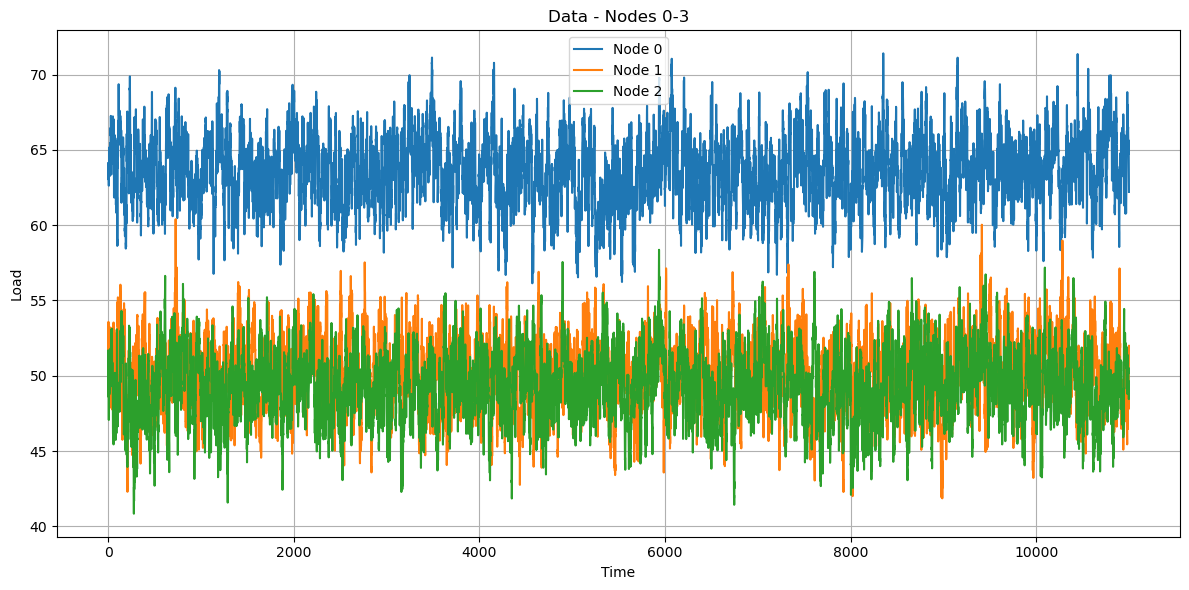

In [4]:
ar1_data_train_val_manage.plot_range_data(ar1_data_train_val_manage.data_np[:3, :], title='Data')


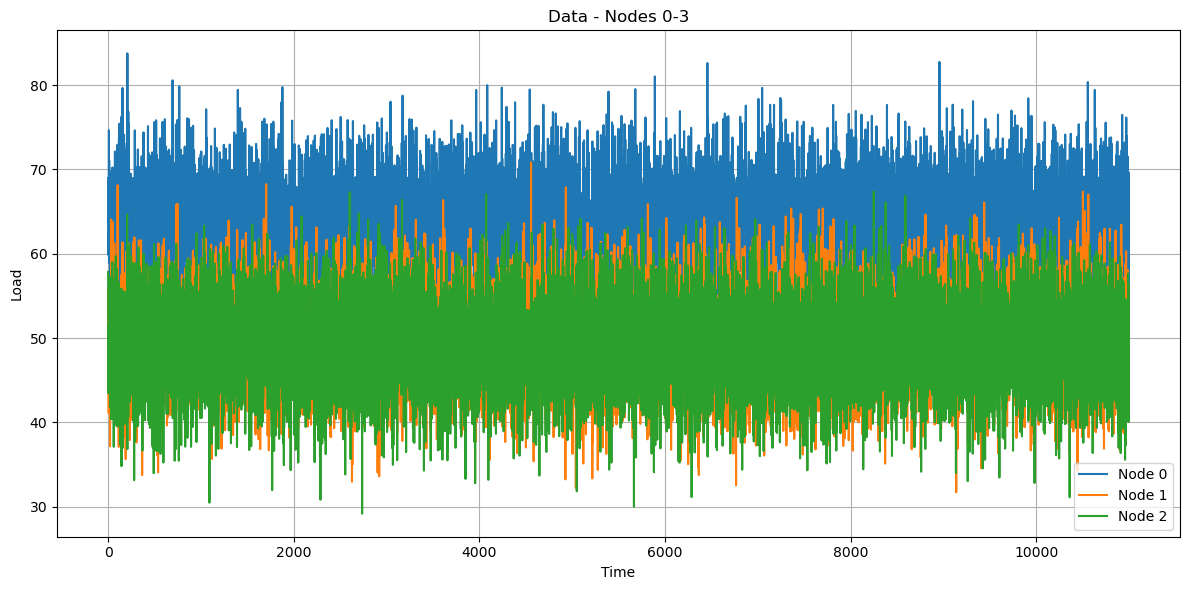

In [5]:
iid_data_train_val_manage.plot_range_data(iid_data_train_val_manage.data_np[:3, :], title='Data')

In [6]:
class ARExpert:
    """
    AR专家，每次预测后都会使用全部的历史数据（而不是移动窗口）更新模型，然后再进行预测
    
    参数:
    - data: ndarray, 每行代表一个节点的负载数据， shape 为 (N, T_train + T_test)
    - order: int, AR模型的阶数
    """

    def __init__(self, config: DictConfig, data_manage) -> None:
        self.config = config
        self.data_manage = data_manage

        # 从配置文件中提取所需的配置项
        base_config = config.base
        ar_config = config.exp4.ARconfig

        self.N: int = base_config.N
        self.data: np.ndarray = self.data_manage.data_np
        self.order: int = ar_config.order  # AR 模型的阶数
        self.T: int = base_config.T
        self.T_train_val: int = base_config.T_train_val
        self.T_train: int = base_config.T_train
        self.T_val: int = base_config.T_val
        self.T_test: int = base_config.T_test

        self.train_val_data: np.ndarray = self.data_manage.train_val_data_np
        self.test_data: np.ndarray = self.data_manage.test_data_np

        # 预先分配 joint_train_data 的空间
        self.joint_train_data: np.ndarray = np.zeros((self.N, self.T_train_val + self.T_test))
        # 将训练验证数据填充到 joint_train_data 中
        self.joint_train_data[:, :self.T_train_val] = self.train_val_data

        # 为每个节点训练一个 AR 模型
        self.models = [
            AutoReg(self.joint_train_data[i, :self.T_train_val], lags=self.order).fit() for i in range(self.N)
        ]

        self.predictions: np.ndarray = np.zeros((self.N, self.T_test))  # 存储每次的预测结果
        self.true_values: np.ndarray = np.zeros((self.N, self.T_test))  # 存储每次的真实数据
        self.losses: np.ndarray = np.zeros((self.N, self.T_test))  # 存储每次的损失

    def predict_and_update(self) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        执行预测并更新 AR 模型。

        :return: 返回预测值、真实值和损失值的元组
        """
        for t in range(self.T_test):

            # 预测
            predictions = [self.models[i].predict(start=self.T_train_val + t, end=self.T_train_val + t) for i in range(self.N)]
            self.predictions[:, t] = np.array(predictions).flatten()

            if t < self.T_test - 1:
                # 获取真实值并更新 joint_train_data
                self.true_values[:, t] = self.test_data[:, t]
                self.joint_train_data[:, self.T_train_val + t] = self.true_values[:, t]

                # 更新所有节点的模型
                self.models = [
                    AutoReg(self.joint_train_data[i, :self.T_train_val + t + 1], lags=self.order).fit() for i in range(self.N)
                ]
            else:
                self.true_values[:, t] = self.test_data[:, t]

            if t % 50 == 0 or t == self.T_test:
                print(f't={t}, joint_train_data.shape={self.joint_train_data.shape}')
                # , flush=True)
                # sys.stdout.flush()
                print(f'Node {t}: Predicted: {self.predictions[:, t]}, True: {self.true_values[:, t]}')
                # for i, model in enumerate(self.models):
                #     print(f'Node {i}: AR coefficients: {model.params}')

        self.losses = self.compute_loss(self.predictions, self.true_values)
        return self.predictions, self.true_values, self.losses

    def compute_loss(self, predictions: np.ndarray, true_values: np.ndarray) -> np.ndarray:
        """
        计算损失（均方误差）。

        :param predictions: 预测值
        :param true_values: 真实值
        :return: 损失值
        """
        return np.mean((predictions - true_values) ** 2, axis=0)

    def get_predictions(self) -> np.ndarray:
        return self.predictions

    def get_true_values(self) -> np.ndarray:
        return self.true_values

    def get_losses(self) -> np.ndarray:
        return self.losses

    def plot_losses(self) -> None:
        """
        绘制预测损失图。
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Loss')
        plt.title('Prediction Loss over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_predictions(self, node_index: int, start: int = 0, end: int = 11000) -> None:
        """
        绘制预测和真实数据图。

        :param node_index: 节点索引
        :param start: 开始时间步
        :param end: 结束时间步
        """
        plt.figure(figsize=(10, 6))

        # 绘制真实数据
        if start < self.T_train_val:
            plt.plot(range(start, min(end, self.T_train_val)),
                     self.train_val_data[node_index][start:min(end, self.T_train_val)],
                     label='True Data (Train)')
        if end > self.T_train_val:
            plt.plot(range(max(start, self.T_train_val), end),
                     self.test_data[node_index][max(0, start - self.T_train_val):end - self.T_train_val],
                     label='True Data (Test)')

        # 绘制预测数据
        plt.plot(range(max(self.T_train_val, start), min(end, self.T_train_val + self.T_test)),
                 self.predictions[node_index][max(0, start - self.T_train_val):min(end - self.T_train_val, self.T_test)],
                 label='Predictions', linestyle='--')

        plt.title(f'Predictions for Node {node_index}')
        plt.xlabel('Time Step')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.show()

In [7]:
# import os
# os.environ['PYTHONUNBUFFERED'] = '1'


In [8]:
%%time
# 创建 ARExpert 对象并执行预测与更新
ar1_ar_expert = ARExpert(config, ar1_data_train_val_manage)
predictions, true_values, losses = ar1_ar_expert.predict_and_update()
losses.sum()

t=0, joint_train_data.shape=(10, 11000)
Node 0: Predicted: [61.37435927 51.20765232 47.80345103 59.02946427 58.3242179  59.87377069
 35.74588746 43.4720653  44.92452889 21.59904649], True: [59.84011078 49.42193604 47.00801468 59.58929825 59.82989502 59.65480804
 35.04138184 44.19546509 45.78972244 21.46299553]
t=50, joint_train_data.shape=(10, 11000)
Node 50: Predicted: [62.32305978 52.05332817 43.94689532 62.12631942 61.1436537  58.25336262
 31.92036067 45.88844811 41.93268321 23.27927408], True: [62.75706482 53.30619049 44.57879639 61.12944794 62.4748497  58.044384
 32.39668655 45.45664215 43.00667572 21.86404991]
t=100, joint_train_data.shape=(10, 11000)
Node 100: Predicted: [66.73565021 52.32144646 49.3750021  64.2672852  65.17122331 57.09382196
 37.83068574 42.94664127 49.49354289 19.506007  ], True: [67.78479767 51.85282135 49.97057724 65.32562256 64.89239502 57.15182495
 38.40499115 44.37283325 49.62432098 20.10758018]
t=150, joint_train_data.shape=(10, 11000)
Node 150: Predicte

995.6529223043001

In [9]:
ar1_ar_expert.get_predictions().shape

(10, 1000)

In [10]:
np.savetxt('../Data/AR_predictions.csv', predictions, delimiter=',', header='')


In [30]:
# predictions

In [12]:
test = np.loadtxt('../Data/AR_predictions.csv', delimiter=',')

In [29]:
# test

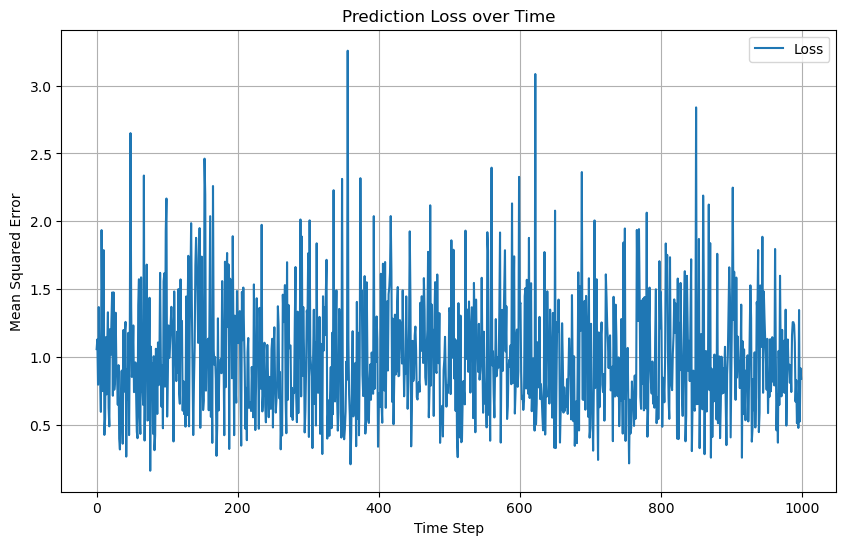

In [14]:
# 绘制损失
ar1_ar_expert.plot_losses()

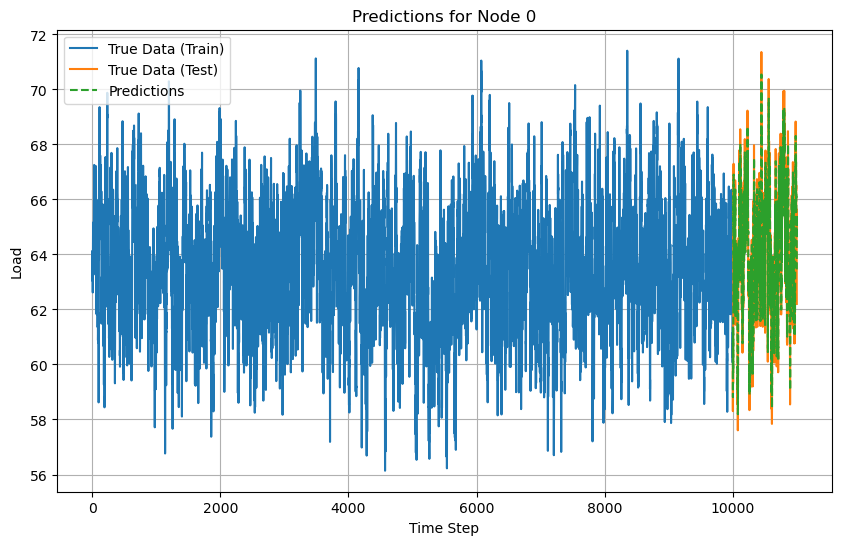

In [15]:
# 绘制预测结果
ar1_ar_expert.plot_predictions(node_index=0)


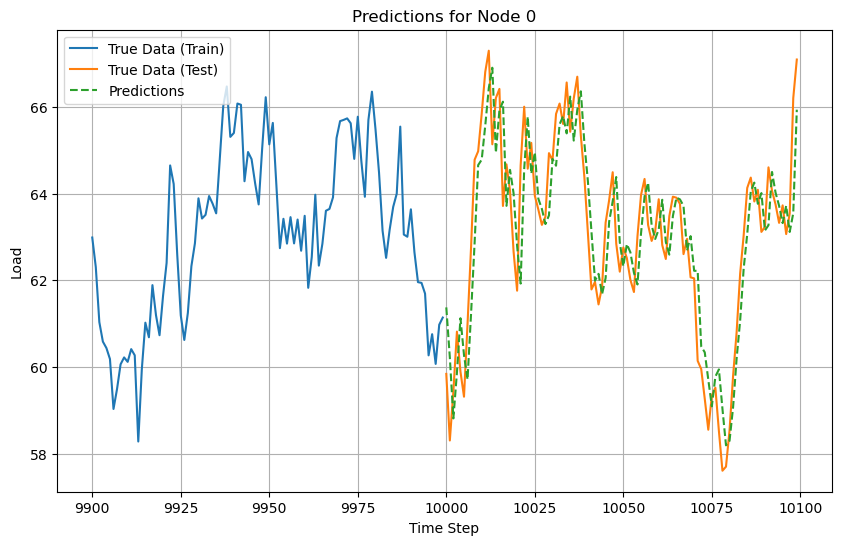

In [16]:
ar1_ar_expert.plot_predictions(node_index=0, start=9900, end=10100)

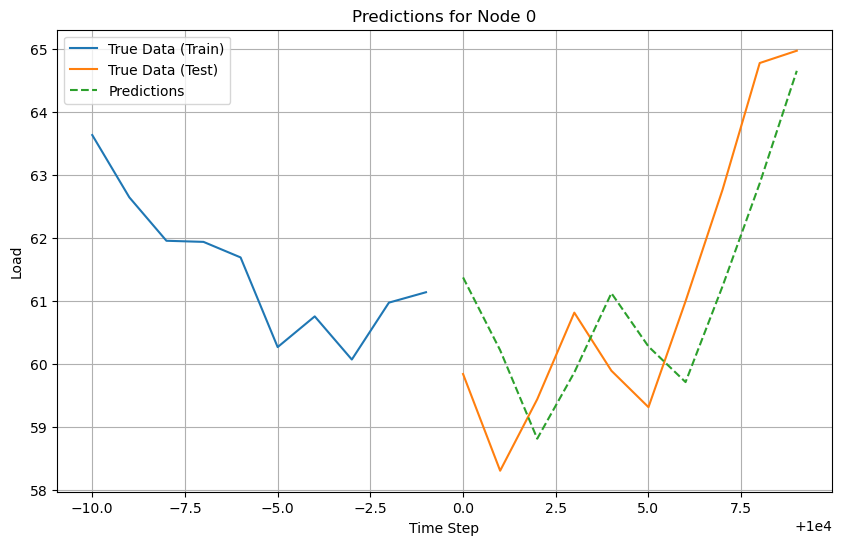

In [17]:
ar1_ar_expert.plot_predictions(node_index=0, start=9990, end=10010)

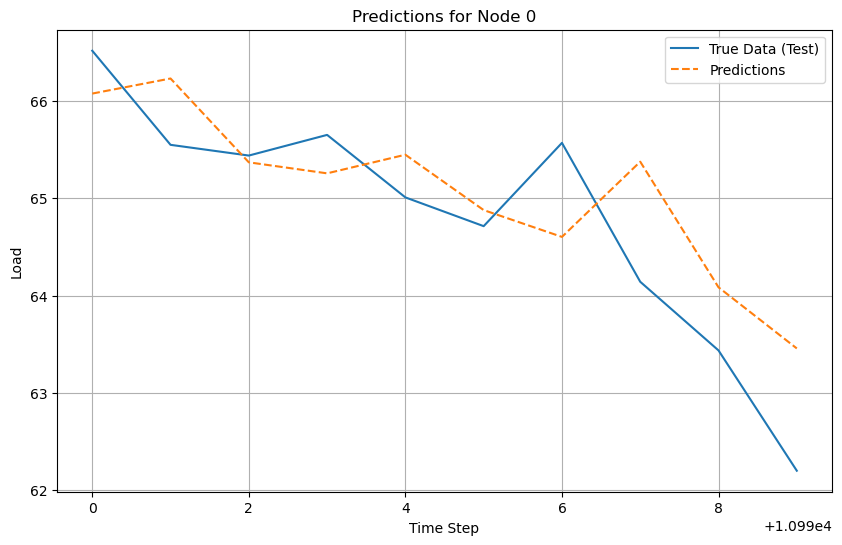

In [18]:
ar1_ar_expert.plot_predictions(node_index=0, start=10990, end=11000)

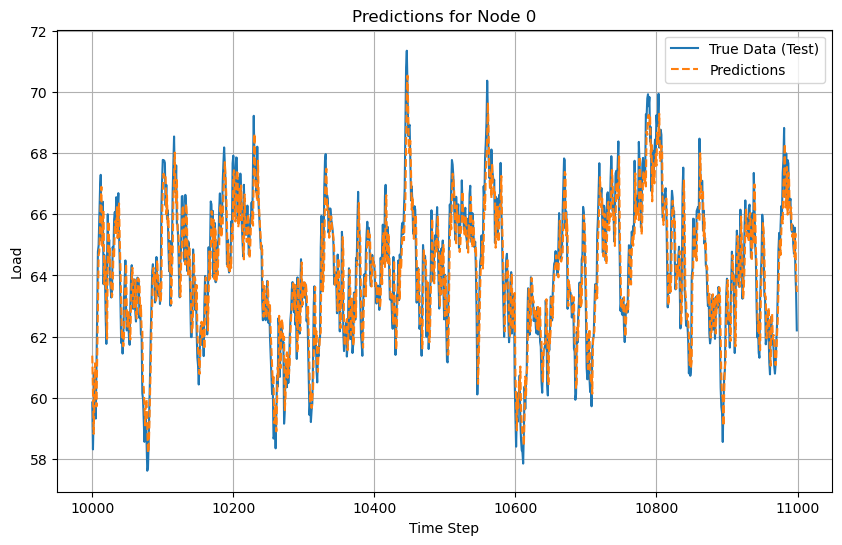

In [19]:
ar1_ar_expert.plot_predictions(node_index=0, start=10000, end=11000)

In [20]:
%%time
# 创建 ARExpert 对象并执行预测与更新
iid_ar_expert = ARExpert(config, iid_data_train_val_manage)
predictions, true_values, losses = iid_ar_expert.predict_and_update()
losses.sum()

t=0, joint_train_data.shape=(10, 11000)
Node 0: Predicted: [63.75652166 50.16509168 49.20755678 62.25651715 63.6306338  58.79218396
 34.89166343 43.86188047 46.66563719 22.06394862], True: [66.61327436 48.63615054 51.06624446 66.032645   57.49646981 66.35295894
 37.26796323 47.98065525 47.05167142 21.28556732]
t=50, joint_train_data.shape=(10, 11000)
Node 50: Predicted: [63.52543006 50.11307134 49.21004217 62.06274889 63.53131482 59.0013996
 34.87928554 44.07707668 46.93921354 22.12473929], True: [61.59650279 51.99516399 58.01714522 58.40029337 59.79427471 60.8973909
 32.84008285 53.0841301  54.07230883 24.75186982]
t=100, joint_train_data.shape=(10, 11000)
Node 100: Predicted: [63.52948449 50.09154562 49.17970102 62.01444    63.58648823 59.18672145
 34.73714305 43.96123476 46.68592892 22.24478873], True: [58.38223858 46.59029232 52.41580452 56.27964411 65.60158913 57.01485893
 37.61976971 47.53278812 47.43657993 13.75694506]
t=150, joint_train_data.shape=(10, 11000)
Node 150: Predicte

24940.7946944637

In [21]:
iid_ar_expert.get_predictions().shape

(10, 1000)

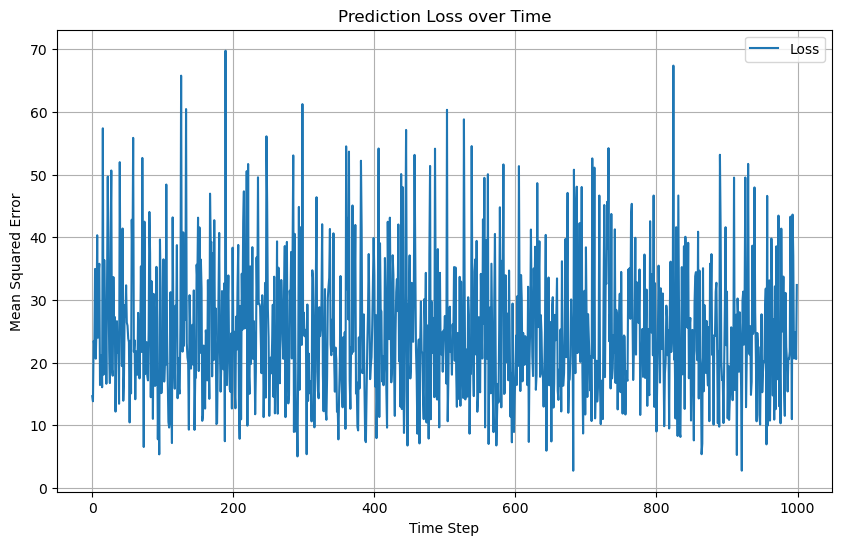

In [22]:
# 绘制损失
iid_ar_expert.plot_losses()

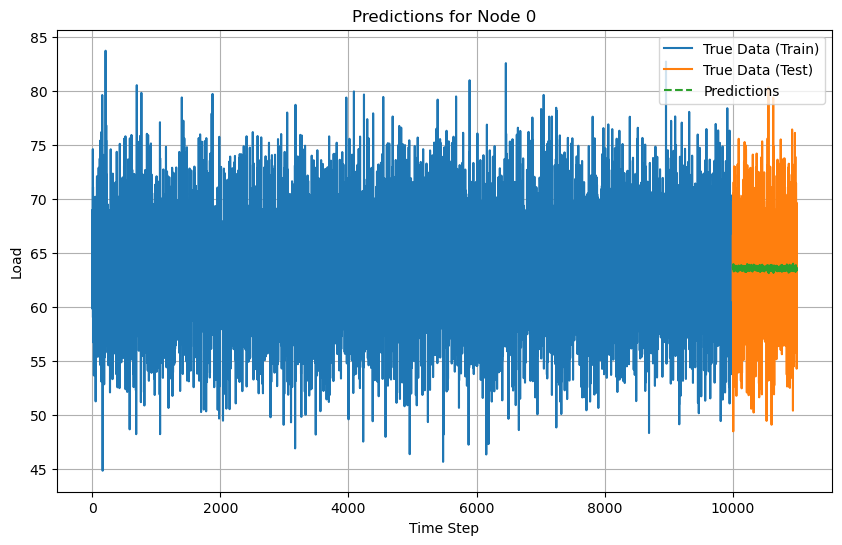

In [23]:
# 绘制预测结果
iid_ar_expert.plot_predictions(node_index=0)


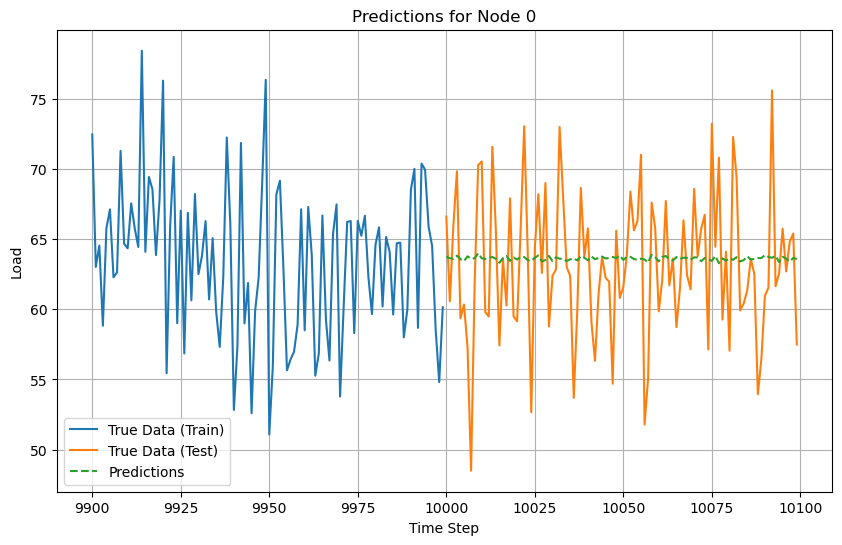

In [24]:
iid_ar_expert.plot_predictions(node_index=0, start=9900, end=10100)

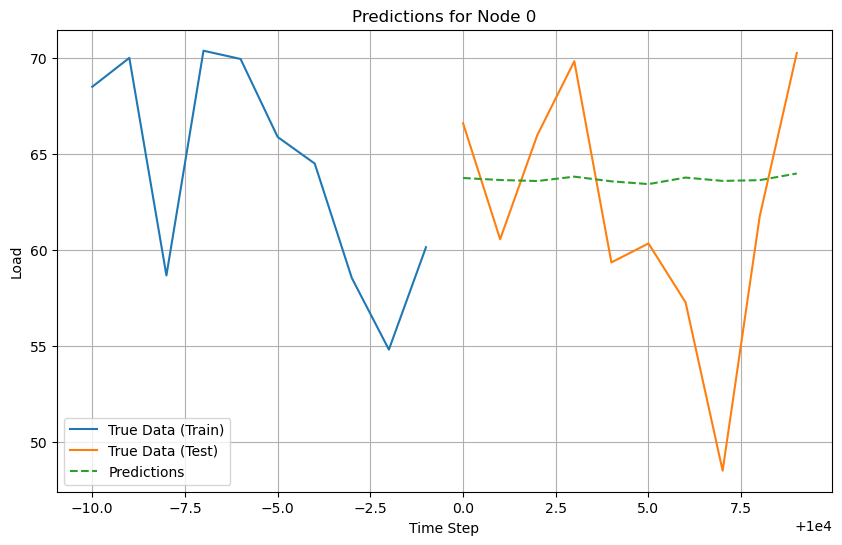

In [25]:
iid_ar_expert.plot_predictions(node_index=0, start=9990, end=10010)

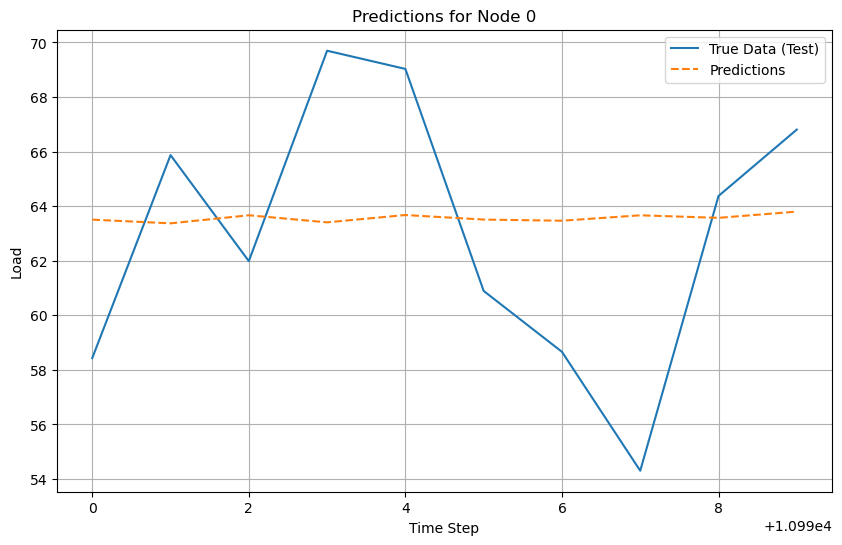

In [26]:
iid_ar_expert.plot_predictions(node_index=0, start=10990, end=11000)

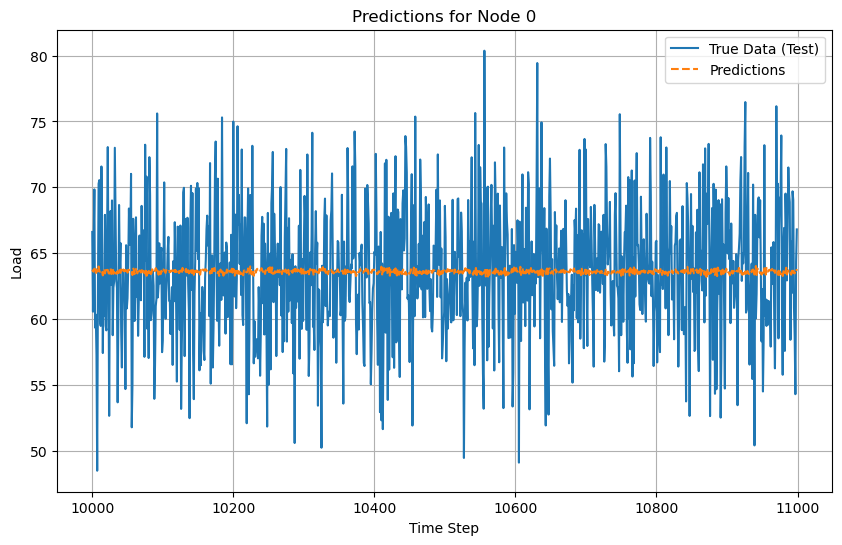

In [27]:
iid_ar_expert.plot_predictions(node_index=0, start=10000, end=11000)